## **Introduction** 

This notebook aims to create a tensorflow model to translate/classify videos of american sign language.

We are using two datasets for the model, Google - Isolated Sign Language Recognition (GISLR) and World Level American Sign Language (WLASL). These two datasets are combined and shuffled for the training process of the model.

We are using mediapipe to get landmark data from the WLASL dataset. Since GISLR is already in the form of mediapipe landmarks, we don't need to change anything.

---

## **Importing Libraries** 

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['GLOG_minloglevel'] = '2'
import time
import gc
import cv2
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, HTML
import requests
from PIL import Image
from io import BytesIO
import pickle
from scipy.interpolate import interp1d
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

We will define some directory locations and hyper parameters

In [2]:

WLASL_DIR = 'datasets/wlasl_dataset'
WLASL_VIDEO_DIR = f'{WLASL_DIR}/videos'
WLASL_BACKUP = 'datasets/wlasl2000_resized'
WLASL_BACKUP_VIDEO_DIR= f'{WLASL_BACKUP}/videos'
NPY_DIR = 'working/landmarks'
GISLR_DIR = 'datasets/google_isolated_sl'
MEDIAPIPE_MODELS_DIR = 'datasets/mediapipe_models'
os.makedirs('working', exist_ok=True)
os.makedirs(NPY_DIR, exist_ok=True)

MAX_FRAME_LENGTH = 64
N_EPOCHS = 100

---

## **JSON Load**

We will load the json with the video details and put it to a dataframe

In [3]:
def get_dataset_json(json):
    data = []
    
    for i in tqdm(range(len(json))):
        gloss = json[i]['gloss']
        instances = json[i]['instances']
        for instance in instances:
            video_id = instance['video_id']
            if os.path.exists(os.path.join(WLASL_VIDEO_DIR, f'{video_id}.mp4')):
                video_path = os.path.join(WLASL_VIDEO_DIR, f'{video_id}.mp4')
            elif os.path.exists(os.path.join(WLASL_BACKUP_VIDEO_DIR, f'{video_id}.mp4')):
                video_path = os.path.join(WLASL_BACKUP_VIDEO_DIR, f'{video_id}.mp4')
            else:
                continue
            
            frame_start = instance['frame_start']
            frame_end = instance['frame_end']
            split = instance['split']
            data.append({
                'gloss': gloss,
                'video_path': video_path,
                'frame_start': frame_start,
                'frame_end': frame_end,
                'split': split
            })
    
    return pd.DataFrame(data)

In [4]:
with open(f'{WLASL_DIR}/WLASL_v0.3.json', 'r') as json_file:
    wlasl_json = json.load(json_file)

wlasl_df = get_dataset_json(wlasl_json)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
wlasl_df.head()

gloss                                   video_path  frame_start  frame_end  \
0  book      datasets/wlasl_dataset/videos/69241.mp4            1         -1   
1  book  datasets/wlasl2000_resized/videos/65225.mp4            1         -1   
2  book  datasets/wlasl2000_resized/videos/68011.mp4            1         -1   
3  book  datasets/wlasl2000_resized/videos/68208.mp4            1         60   
4  book  datasets/wlasl2000_resized/videos/68012.mp4            1         -1   

   split  
0  train  
1  train  
2  train  
3  train  
4  train

---

## **Landmark Detection**

We don't need all 553 landmarks that mediapipe can give us for a single person. We will need to filter the useful landmarks for our purpose.

In [6]:
HAND_FILTERS = list(range(21))
POSE_FILTERS = [0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16]
FACE_FILTERS = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
HAND_FILTERS_LEN = len(HAND_FILTERS) # 21
POSE_FILTERS_LEN = len(POSE_FILTERS) # 13
FACE_FILTERS_LEN = len(FACE_FILTERS) # 40
TOTAL_FILTERS_LEN = HAND_FILTERS_LEN * 2 + POSE_FILTERS_LEN + FACE_FILTERS_LEN

Define the options for the models used by mediapipe

In [ ]:
vision_running_mode = vision.RunningMode
base_options = python.BaseOptions

hands_options_image = vision.HandLandmarkerOptions(
    running_mode=vision_running_mode.IMAGE,
    min_hand_detection_confidence=0.55,
    base_options=base_options(model_asset_path=f'{MEDIAPIPE_MODELS_DIR}/hand_landmarker.task'),
    num_hands=2
)

pose_options_image = vision.PoseLandmarkerOptions(
    running_mode=vision_running_mode.IMAGE,
    min_pose_detection_confidence=0.55,
    base_options=base_options(model_asset_path=f'{MEDIAPIPE_MODELS_DIR}/pose_landmarker_full.task')
)

face_options_image = vision.FaceLandmarkerOptions(
    running_mode=vision_running_mode.IMAGE,
    min_face_detection_confidence=0.55,
    base_options=base_options(model_asset_path=f'{MEDIAPIPE_MODELS_DIR}/face_landmarker.task')
)

hands_options_video = vision.HandLandmarkerOptions(
    running_mode=vision_running_mode.VIDEO,
    min_hand_detection_confidence=0.55,
    base_options=base_options(model_asset_path=f'{MEDIAPIPE_MODELS_DIR}/hand_landmarker.task'),
    num_hands=2
)

pose_options_video = vision.PoseLandmarkerOptions(
    running_mode=vision_running_mode.VIDEO,
    min_pose_detection_confidence=0.55,
    base_options=base_options(model_asset_path=f'{MEDIAPIPE_MODELS_DIR}/pose_landmarker_full.task')
)

face_options_video = vision.FaceLandmarkerOptions(
    running_mode=vision_running_mode.VIDEO,
    min_face_detection_confidence=0.55,
    base_options=base_options(model_asset_path=f'{MEDIAPIPE_MODELS_DIR}/face_landmarker.task')
)

# We only used image detector for testing purposes
hands_detector_image = vision.HandLandmarker.create_from_options(hands_options_image)
pose_detector_image = vision.PoseLandmarker.create_from_options(pose_options_image)
face_detector_image = vision.FaceLandmarker.create_from_options(face_options_image)
IMAGE_DETECTORS = (hands_detector_image, pose_detector_image, face_detector_image)

Define functions to detect landmarks from images and videos

In [8]:
def detect(detector, image, frame_timestamp=None):
    if frame_timestamp is None:
        return detector.detect(image)
    else:
        return detector.detect_for_video(image, frame_timestamp)

def process_landmarks(landmarks, filters, start_idx, landmarks_array):
    for i in filters:
        landmarks_array[start_idx] = [landmarks[i].x, landmarks[i].y]
        start_idx += 1
    return start_idx

def extract_landmarks_from_image(image, detectors, timestamp=None):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
    
    hands_detector, pose_detector, face_detector = detectors

    with ThreadPoolExecutor() as executor:
        detect_args = (mp_image, timestamp) if timestamp != None else (mp_image,)
        
        hands_future = executor.submit(detect, hands_detector, *detect_args)
        pose_future = executor.submit(detect, pose_detector, *detect_args)
        face_future = executor.submit(detect, face_detector, *detect_args)
        
        hand_result = hands_future.result()
        pose_result = pose_future.result()
        face_result = face_future.result()

    hand_landmarks = hand_result.hand_landmarks
    pose_landmarks = pose_result.pose_landmarks
    face_landmarks = face_result.face_landmarks

    landmarks_array = np.full((TOTAL_FILTERS_LEN, 2), np.nan)
    arr_idx = 0
    
    if hand_landmarks:
        if hand_result.handedness[0].index == 1:
            arr_idx += HAND_FILTERS_LEN
        
        for landmarks in hand_landmarks:
            arr_idx = process_landmarks(landmarks, HAND_FILTERS, arr_idx, landmarks_array)
        
        if arr_idx == HAND_FILTERS_LEN:
            arr_idx += HAND_FILTERS_LEN
    else:
        arr_idx += HAND_FILTERS_LEN*2

    if pose_landmarks:
        arr_idx = process_landmarks(pose_landmarks[0], POSE_FILTERS, arr_idx, landmarks_array)
    else:
        arr_idx += POSE_FILTERS_LEN

    if face_landmarks:
        arr_idx = process_landmarks(face_landmarks[0], FACE_FILTERS, arr_idx, landmarks_array)
    else:
        arr_idx += FACE_FILTERS_LEN
    
    return landmarks_array

def extract_landmarks_from_video(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = round(cap.get(cv2.CAP_PROP_FPS))
    frame_duration_ms = 1000 / fps
    
    hands_detector_video = vision.HandLandmarker.create_from_options(hands_options_video)
    pose_detector_video = vision.PoseLandmarker.create_from_options(pose_options_video)
    face_detector_video = vision.FaceLandmarker.create_from_options(face_options_video)
    VIDEO_DETECTORS = (hands_detector_video, pose_detector_video, face_detector_video)
    
    if start_frame < 1:
        start_frame = 1
    elif start_frame > total_frames:
        start_frame = 1
    
    if end_frame < 0 or end_frame > total_frames:
        end_frame = total_frames
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame - 1)
    video_landmarks = np.zeros((end_frame - start_frame + 1, TOTAL_FILTERS_LEN, 2), dtype=object)
    
    for frame_idx in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        
        timestamp = int((frame_idx - 1) * frame_duration_ms)
        
        # landmarks = extract_landmarks_from_image(frame, IMAGE_DETECTORS)
        landmarks = extract_landmarks_from_image(frame, VIDEO_DETECTORS, timestamp)
        video_landmarks[frame_idx - start_frame] = landmarks
    
    cap.release()
    return video_landmarks

Functions used to test landmarks result

In [9]:
def draw_landmarks_image(image, landmarks, dot_size=5):
    for landmark in landmarks:
        x, y = landmark
        if not np.isnan(x) and not np.isnan(y):
            cv2.circle(image, (int(x * image.shape[1]), int(y * image.shape[0])), dot_size, (0, 255, 0), -1)
    return image

# this function is somewhat unstable, sometimes the total_frames is not correct
def draw_landmarks_video(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1, dot_size=5):
    cap = cv2.VideoCapture(input_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    if end_frame == -1 or end_frame > total_frames:
        end_frame = total_frames

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame - 1)

    while cap.isOpened():
        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_number > end_frame:
            break

        ret, frame = cap.read()
        if not ret:
            break

        frame_landmarks = video_landmarks[frame_number - 1]
        annotated_frame = draw_landmarks_image(frame, frame_landmarks, dot_size=dot_size)

        out.write(annotated_frame)

    cap.release()
    out.release()


Function to animate landmarks directly for testing purposes

In [10]:
def plot_frame(frame, ax):
    ax.clear()
    x = frame[:, 0]
    y = frame[:, 1]
    ax.scatter(x, y, color='dodgerblue')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def animate_frames(data):
    fig, ax = plt.subplots()
    anim = FuncAnimation(fig, lambda frame: plot_frame(data[frame], ax), frames=range(data.shape[0]), interval=100)
    plt.close(fig)
    return HTML(anim.to_jshtml())

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


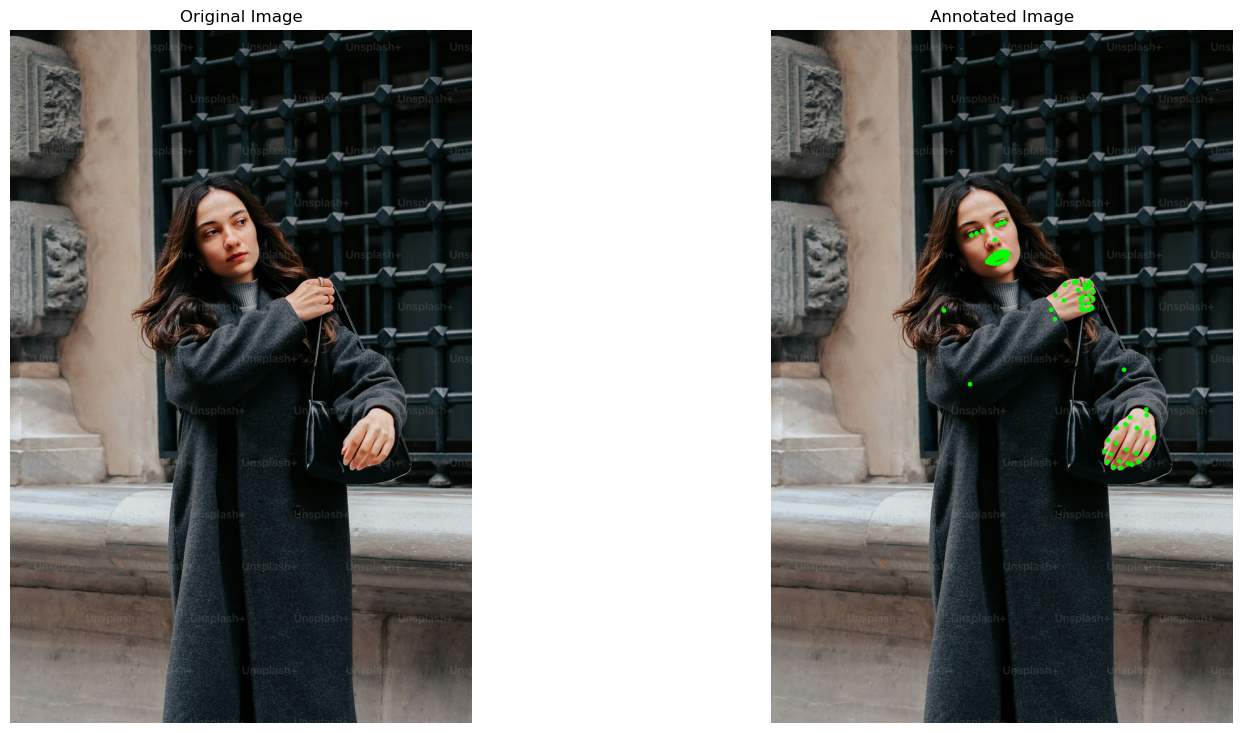

In [11]:
# Fetch and process the image
image_url = 'https://plus.unsplash.com/premium_photo-1673287635678-8d812deb4fc2?q=80&w=1974&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' # all
# image_url = 'https://images.unsplash.com/photo-1626006864202-946131e379dd?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'# only left hand
# image_url = 'https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?q=80&w=1974&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' # only face
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

# Annotate the image
test_image_landmarks = extract_landmarks_from_image(img, IMAGE_DETECTORS)
annotated_img = draw_landmarks_image(img.copy(), test_image_landmarks, 10)

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Original image
axes[0].imshow(img[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Original Image')

# Annotated image
axes[1].imshow(annotated_img[:,:,::-1])
axes[1].axis('off')
axes[1].set_title('Annotated Image')

plt.show()

# Save the annotated image
Image.fromarray(annotated_img).save("working/test_output_image.png")

In [ ]:
test_video = wlasl_df.iloc[353]
video_path = test_video['video_path']
frame_start = test_video['frame_start']
frame_end = test_video['frame_end']
output_path = 'working/test_output_video.mp4'
test_video_landmarks = extract_landmarks_from_video(video_path, frame_start, frame_end)
draw_landmarks_video(video_path, output_path, test_video_landmarks, start_frame=frame_start, end_frame=frame_end, dot_size=5)

In [13]:
gc.collect()

23

In [14]:
animate_frames(test_video_landmarks)

---

## **Landmark Encoding**

Encode all video from the WLASL dataset to landmark data and save them as npy files

In [15]:
try:
    for i in tqdm(range(len(wlasl_df))):
        npy_path = os.path.join(NPY_DIR, f'{i}.npy')
        if os.path.exists(npy_path): continue
        video_path = wlasl_df.iloc[i]['video_path']
        start = wlasl_df.iloc[i]['frame_start']
        end = wlasl_df.iloc[i]['frame_end']
        
        try:
            video_landmarks = extract_landmarks_from_video(video_path, start, end).astype(np.float32)
            np.save(npy_path, video_landmarks, allow_pickle=True)
        
        except Exception as e:
            print(f"\nError loading {video_path}\n{e}")
            continue
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

  0%|          | 0/21083 [00:00<?, ?it/s]

Combine all npy files to npz

In [16]:
landmarks_dict = {}

if not os.path.exists('working/landmarks.npz'):
    for filename in tqdm(os.listdir(NPY_DIR), desc='Processing files'):
        if filename.endswith('.npy'):
            key = filename.split('.')[0]
            landmarks = np.load(os.path.join(NPY_DIR, filename), allow_pickle=True)
            landmarks_dict[key] = landmarks

    np.savez_compressed('working/landmarks.npz', **landmarks_dict)

---

## **Data Augmentation**

Define some augmentation functions

In [17]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data_flat = data[:, :, :2].reshape(-1, 2)
    non_zero_flat_indices = non_zero[:, 0] * landmarks + non_zero[:, 1]
    data_flat[non_zero_flat_indices] -= center
    data_flat[non_zero_flat_indices] = np.dot(data_flat[non_zero_flat_indices], rotation_matrix.T)
    data_flat[non_zero_flat_indices] += center
    data[:, :, :2] = data_flat.reshape(frames, landmarks, 2)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    angle = np.random.choice([np.random.uniform(-30, -5), np.random.uniform(5, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def zoom(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x_shift = np.random.uniform(-0.15, 0.15)
    y_shift = np.random.uniform(-0.15, 0.15)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shear(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    shear_factor_x = np.random.uniform(-0.15, 0.15)
    shear_factor_y = np.random.uniform(-0.15, 0.15)
    
    shear_matrix = np.array([
        [1, shear_factor_x],
        [shear_factor_y, 1]
    ])
    
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data_flat = data[:, :, :2].reshape(-1, 2)
    non_zero_flat_indices = non_zero[:, 0] * landmarks + non_zero[:, 1]
    data_flat[non_zero_flat_indices] -= center
    data_flat[non_zero_flat_indices] = np.dot(data_flat[non_zero_flat_indices], shear_matrix.T)
    data_flat[non_zero_flat_indices] += center
    data[:, :, :2] = data_flat.reshape(frames, landmarks, 2)
    
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    
    return data

def cutout(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    frames, landmarks, _ = data.shape
    
    box_height_fraction = np.random.uniform(0.1, 0.2)
    box_width_fraction = np.random.uniform(0.1, 0.2)
    
    box_center_x = np.random.uniform(box_width_fraction / 2, 1 - box_width_fraction / 2)
    box_center_y = np.random.uniform(box_height_fraction / 2, 1 - box_height_fraction / 2)
    
    box_min_x = box_center_x - box_width_fraction / 2
    box_max_x = box_center_x + box_width_fraction / 2
    box_min_y = box_center_y - box_height_fraction / 2
    box_max_y = box_center_y + box_height_fraction / 2
    
    for frame in range(frames):
        for landmark in range(landmarks):
            x, y = data[frame, landmark, :2]
            if box_min_x <= x <= box_max_x and box_min_y <= y <= box_max_y:
                data[frame, landmark, :] = 0
    
    return data

In [18]:
def augment_video(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    if np.random.uniform() < 0.5:
        data = rotate_z(data)
    if np.random.uniform() < 0.5:
        data = zoom(data)
    if np.random.uniform() < 0.5:
        data = shift(data)
    if np.random.uniform() < 0.5:
        data = shear(data)
    if np.random.uniform() < 0.5:
        data = cutout(data)
    
    return data

In [19]:
def generate_augmented_samples(data_list, labels_list, num_augmentations=5, seed=None):
    augmented_samples_x = []
    augmented_samples_y = []
    
    for x, y in tqdm(zip(data_list, labels_list), total=len(data_list), desc="Processing samples"):
        for i in range(num_augmentations):
            if seed is not None:
                np.random.seed(seed + i)
            augmented_data = augment_video(np.copy(x), seed)
            augmented_samples_x.append(augmented_data)
            augmented_samples_y.append(np.copy(y))
        
    return np.array(augmented_samples_x), np.array(augmented_samples_y)

In [20]:
def test_augment_img(data, img):
    real_img = img.copy()
    for landmark in data[0]:
        x, y = landmark
        if not np.isnan(x) and not np.isnan(y):
            cv2.circle(real_img, (int(x * real_img.shape[1]), int(y * real_img.shape[0])), 20, (0, 255, 0), -1)
    plt.figure(figsize=(6, 6))
    plt.imshow(real_img[:,:,::-1])
    plt.axis('off')
    plt.show()
    
    aug_functions = [rotate_z, zoom, shift, shear, cutout]
    
    fig, axs = plt.subplots(3, 2, figsize=(12, 12), dpi=500)
    for i, fun in enumerate(aug_functions):
        ax = axs[i // 2, i % 2]
        ax.imshow(draw_landmarks_image(img.copy(), fun(data.copy())[0], 20))
        ax.axis('off')
        ax.set_title(fun.__name__)

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


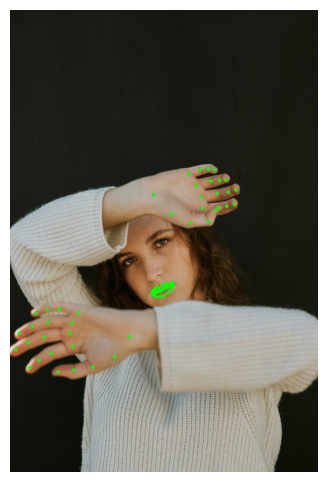

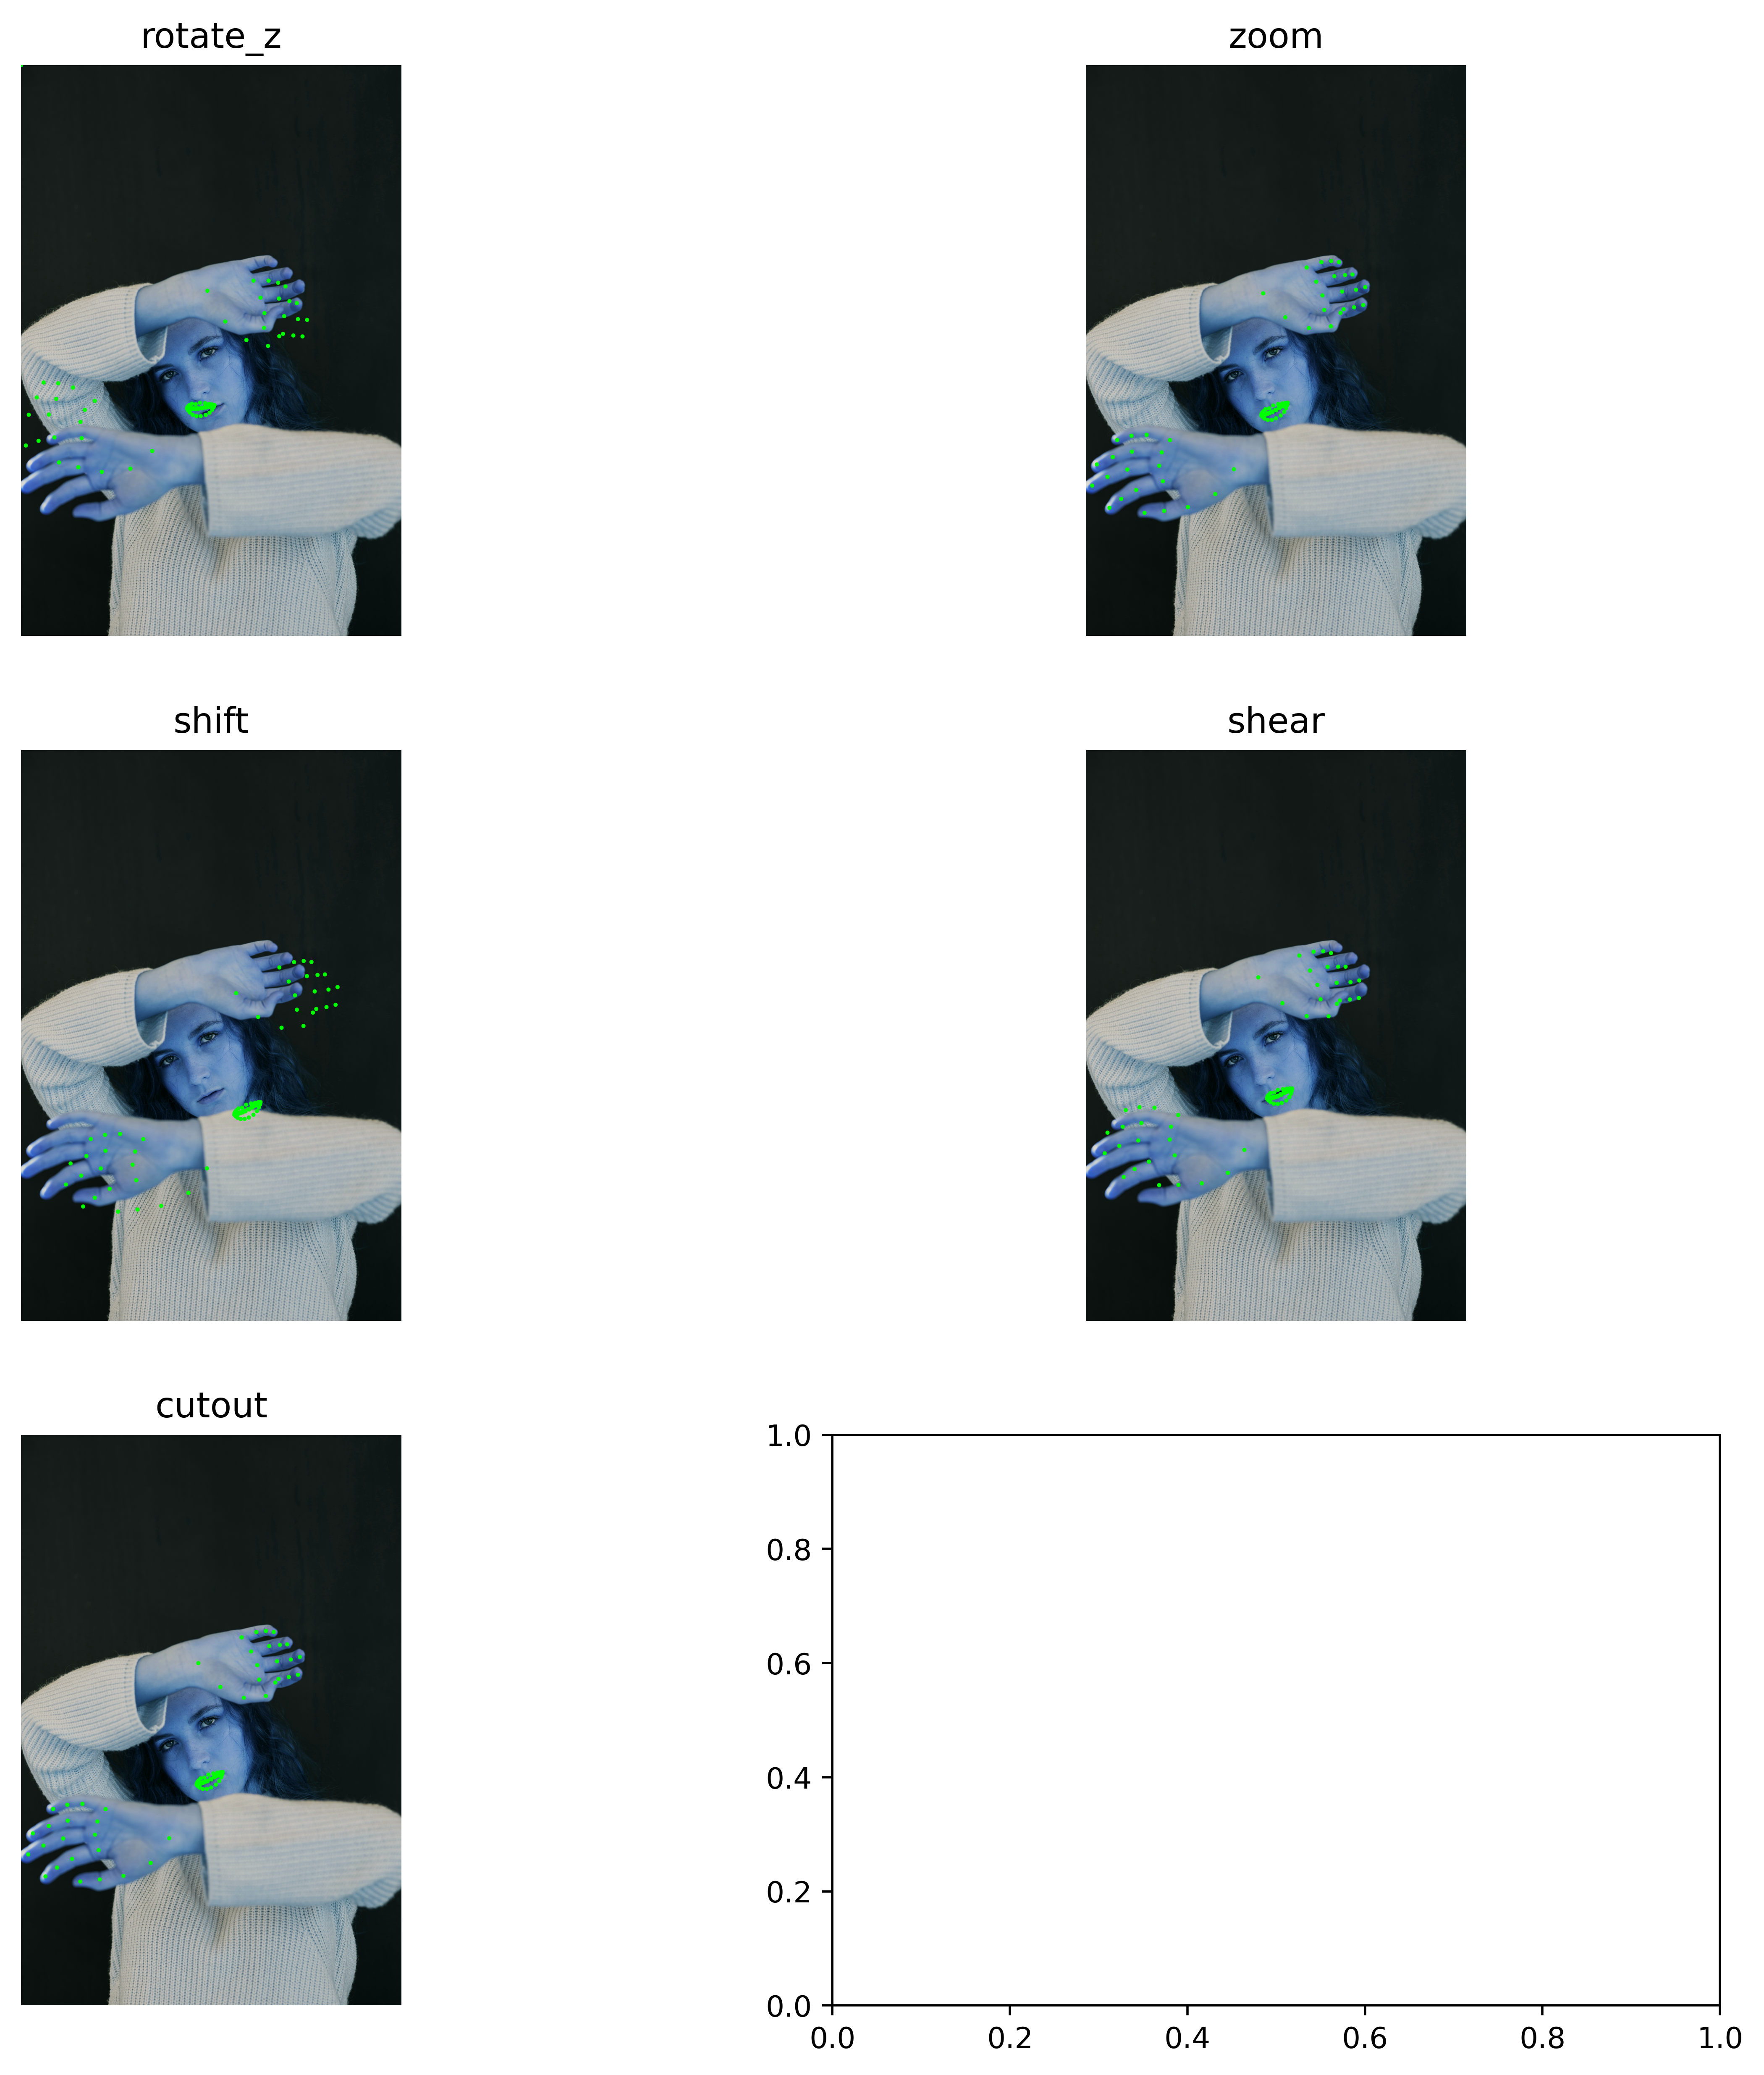

In [21]:
# image_url = 'https://www.solidbackgrounds.com/images/1080x1920/1080x1920-black-solid-color-background.jpg'
image_url = 'https://images.unsplash.com/photo-1515294898968-a408405d7674'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# frame_landmarks = load_pq_data('datasets/google_isolated_sl/train_landmark_files/18796/2324430.parquet')[0]
# np.nan_to_num(frame_landmarks, copy=False, nan=0)

frame_landmarks = extract_landmarks_from_image(img, IMAGE_DETECTORS)
frame_landmarks = np.expand_dims(frame_landmarks, axis=0)

test_augment_img(frame_landmarks.copy(), img)

In [22]:
# video_path = 'datasets/wlasl_dataset/videos/69241.mp4'
# frame_start = 1
# frame_end = -1
# test_video_landmarks = extract_landmarks_from_video(video_path, frame_start, frame_end)
# draw_landmarks_video(
#     video_path,
#     'working/test_output_video_non_augmented.mp4',
#     test_video_landmarks,
#     start_frame=frame_start,
#     end_frame=frame_end
# )

# augmented_video_landmarks = augment_video(test_video_landmarks.copy())
# draw_landmarks_video(
#     video_path,
#     'working/test_output_video_augmented.mp4',
#     augmented_video_landmarks,
#     start_frame=frame_start,
#     end_frame=frame_end
# )

---

## **Preprocess Functions**

Define some preprocess functions

In [23]:
def padding(X, length=None, pad=0):
    if length is None:
        length = X.shape[0]
    
    if X.shape[0] > length:
        X_padded = X[:length]
    else:
        pad_length = length - X.shape[0]
        X_padded = np.pad(
            X, ((0, pad_length), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
        )
    
    return X_padded

def interpolate_sequence(sequence, target_length):
    n, num_landmarks, coords = sequence.shape
    original_indices = np.linspace(0, n-1, n)
    target_indices = np.linspace(0, n-1, target_length)
    interpolated_data = np.zeros((target_length, num_landmarks, coords))
    
    for landmark in range(num_landmarks):
        for coord in range(coords):
            values = sequence[:, landmark, coord]
            interp_func = interp1d(original_indices, values, kind='linear')
            interpolated_data[:, landmark, coord] = interp_func(target_indices)
    
    return interpolated_data

def remove_no_hands(video):
    frames_to_keep = []
    for i, frame in enumerate(video):
        hand_landmarks_data = frame[:43]
        if not np.all(np.isnan(hand_landmarks_data)):
            frames_to_keep.append(i)
    video_with_hands = video[frames_to_keep]
    return video_with_hands

def is_dominant_hand(video):

    left_hand_sum = np.sum(~np.isnan(video[:, slice(0, 21)]), axis=1)
    right_hand_sum = np.sum(~np.isnan(video[:, slice(21, 42)]), axis=1)

    left_dominant_count = np.sum(left_hand_sum >= right_hand_sum)
    right_dominant_count = np.sum(left_hand_sum < right_hand_sum)

    return left_dominant_count > right_dominant_count

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

---

## **Data Load and Preprocess**

Loading function for WLASL npz file

In [24]:
def get_data_and_labels_npz(df, landmarks_dict, filtered_labels=None):
    if filtered_labels is None:
        filtered_labels = []
    x = []
    y = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        real_i = row['original_index']
        gloss = row['gloss']
        
        if gloss not in filtered_labels: continue
        
        video = landmarks_dict[str(real_i)].astype('float32')
        
        x.append(video)
        y.append(gloss)
    
    return x, np.array(y)

Loading function for GISLR parquet files

In [25]:
def load_pq_data(pq_path):
    data_columns = ['x','y']
    data = pd.read_parquet(pq_path, columns = data_columns)
    n_frames = int(len(data) / 543)
    data = data.values.reshape(n_frames, 543, len(data_columns))
    
    left_hand_indices = [468 + i for i in HAND_FILTERS]
    right_hand_indices = [468 + 21 + 33 + i for i in HAND_FILTERS]
    pose_indices = [468 + 21 + i for i in POSE_FILTERS]
    face_indices = FACE_FILTERS
    all_indices = left_hand_indices + right_hand_indices + pose_indices + face_indices
    filtered_data = data[:, all_indices, :]
    
    return filtered_data.astype(np.float32)

def get_data_and_labels_pq(df, pq_dir, filtered_labels=None):
    if filtered_labels is None:
        filtered_labels = []
    x = []
    y = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc='Saving Data as pickle'):
        if row['sign'] not in filtered_labels: continue
        # if np.random.rand() < 0.2: continue

        video = load_pq_data(pq_dir+'/'+row['path'])
        
        x.append(video)
        y.append(row['sign'])
    
    return x, np.array(y)

In [26]:
def preprocess(data, augment=False):
    x = []
    
    for video in tqdm(data, total=len(data), desc='Preprocessing'):
        aug_video = video.copy()
        
        if not is_dominant_hand(aug_video):
            hflip(aug_video)
        
        aug_video = remove_no_hands(aug_video)
        if aug_video.shape[0] == 0:
            continue
        
        # if aug_video.shape[0] > MAX_FRAME_LENGTH:
        #     aug_video = interpolate_sequence(aug_video, MAX_FRAME_LENGTH)
        
        np.nan_to_num(aug_video, copy=False, nan=0)
        
        aug_video = padding(aug_video, MAX_FRAME_LENGTH, -100)
        
        if augment:
            aug_video = augment_video(aug_video)
        
        x.append(aug_video)
    
    return np.array(x)

In [27]:
def create_label_encoder(labels, json_filename='label_encoder.json'):
    unique_labels = np.unique(labels)
    label_to_int = {label: int(idx) for idx, label in enumerate(unique_labels)}

    with open(json_filename, 'w') as json_file:
        json.dump(label_to_int, json_file, indent=4)

def encode_labels(labels, json_filename='label_encoder.json'):
    with open(json_filename, 'r') as json_file:
        label_to_int = json.load(json_file)

    int_labels = np.array([label_to_int[label] for label in labels])
    return int_labels

def load_decoder(json_file_path):
    with open(json_file_path, 'r') as json_file:
        label_to_int = json.load(json_file)
    
    int_to_label = {v: k for k, v in label_to_int.items()}
    return int_to_label

Since we use two datasets with different labels, we need to find the intersection of labels from both datasets

In [28]:
start_time = time.time()

with open(f'{GISLR_DIR}/sign_to_prediction_index_map.json', 'r') as json_file:
    gislr_json = json.load(json_file)

gislr_labels = list(gislr_json.keys())

wlasl_glosses = wlasl_df['gloss'].unique().tolist()

wlasl_glosses_lower = [gloss.lower() for gloss in wlasl_glosses]
gislr_labels_lower = [label.lower() for label in gislr_labels]

filtered_labels = list(set(wlasl_glosses_lower) & set(gislr_labels_lower))
with open('working/filtered_labels.txt', 'w') as file:
    for item in filtered_labels:
        file.write(str(item) + '\n')

Combine all parquet into pkl file

In [29]:
gc.collect()

pq_df = pd.read_csv(f'{GISLR_DIR}/train.csv')

if not (os.path.exists('working/gislr_x.pkl') and os.path.exists('working/gislr_y.pkl')):
    npy_x, npy_y = get_data_and_labels_pq(pq_df, GISLR_DIR, filtered_labels=filtered_labels)

    with open('working/gislr_x.pkl', 'wb') as f:
        pickle.dump(npy_x, f)
    with open('working/gislr_y.pkl', 'wb') as f:
        pickle.dump(npy_y, f)

Load GISLR pickle data and preprocess

In [30]:
with open('working/gislr_x.pkl', 'rb') as f:
    x = pickle.load(f)
with open('working/gislr_y.pkl', 'rb') as f:
    y = pickle.load(f)

x_train_gislr, x_val_gislr, y_train_gislr, y_val_gislr = train_test_split(x, y, test_size=0.1, random_state=42)
x_val_gislr, x_test_gislr, y_val_gislr, y_test_gislr = train_test_split(x_val_gislr, y_val_gislr, test_size=0.5, random_state=42)

x_train_gislr = preprocess(x_train_gislr, augment=True)
x_val_gislr = preprocess(x_val_gislr)
x_test_gislr = preprocess(x_test_gislr)

print()
print("GISLR training data shape:", x_train_gislr.shape, y_train_gislr.shape)
print("GISLR validation data shape:", x_val_gislr.shape, y_val_gislr.shape)
print("GISLR testing data shape:", x_test_gislr.shape, y_test_gislr.shape)

Preprocessing:   0%|          | 0/68114 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/3784 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/3785 [00:00<?, ?it/s]


GISLR training data shape: (68114, 64, 95, 2) (68114,)
GISLR validation data shape: (3784, 64, 95, 2) (3784,)
GISLR testing data shape: (3785, 64, 95, 2) (3785,)


Load WLASL npz data and preprocess. We also generate some augmented data for WLASL since WLASL only has around 1k videos

In [31]:
gc.collect()

all_landmarks = np.load('working/landmarks.npz', allow_pickle=True)

wlasl_df['original_index'] = wlasl_df.index

train_df = wlasl_df[wlasl_df['split'] == 'train']
val_df = wlasl_df[wlasl_df['split'] == 'val']
test_df = wlasl_df[wlasl_df['split'] == 'test']

x_train_wlasl, y_train_wlasl = get_data_and_labels_npz(train_df, all_landmarks, filtered_labels=filtered_labels)
x_val_wlasl, y_val_wlasl = get_data_and_labels_npz(val_df, all_landmarks, filtered_labels=filtered_labels)
x_test_wlasl, y_test_wlasl = get_data_and_labels_npz(test_df, all_landmarks, filtered_labels=filtered_labels)

# x_train_wlasl = preprocess(x_train_wlasl, augment=True)
x_train_wlasl = preprocess(x_train_wlasl)
x_val_wlasl = preprocess(x_val_wlasl)
x_test_wlasl = preprocess(x_test_wlasl)

x_train_wlasl, y_train_wlasl = generate_augmented_samples(x_train_wlasl, y_train_wlasl, num_augmentations=5)

print()
print("WLASL training data shape:", x_train_wlasl.shape, y_train_wlasl.shape)
print("WLASL validation data shape:", x_val_wlasl.shape, y_val_wlasl.shape)
print("WLASL test data shape:", x_test_wlasl.shape, y_test_wlasl.shape)

  0%|          | 0/14289 [00:00<?, ?it/s]

  0%|          | 0/3916 [00:00<?, ?it/s]

  0%|          | 0/2878 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/1943 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/489 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/386 [00:00<?, ?it/s]

Processing samples:   0%|          | 0/1943 [00:00<?, ?it/s]


WLASL training data shape: (9715, 64, 95, 2) (9715,)
WLASL validation data shape: (489, 64, 95, 2) (489,)
WLASL test data shape: (386, 64, 95, 2) (386,)


In [32]:
gc.collect()

x_val = np.concatenate((x_val_gislr, x_val_wlasl), axis=0)
y_val = np.concatenate((y_val_gislr, y_val_wlasl), axis=0)

del x_val_gislr, x_val_wlasl, y_val_gislr, y_val_wlasl

In [33]:
gc.collect()

x_train = np.concatenate((x_train_gislr, x_train_wlasl), axis=0)
y_train = np.concatenate((y_train_gislr, y_train_wlasl), axis=0)

del x_train_gislr, x_train_wlasl, y_train_gislr, y_train_wlasl

# x_test = np.concatenate((x_test_gislr, x_test_wlasl), axis=0)
# y_test = np.concatenate((y_test_gislr, y_test_wlasl), axis=0)

In [34]:
gc.collect()

train_permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[train_permutation]
y_train = y_train[train_permutation]

val_permutation = np.random.permutation(x_val.shape[0])
x_val = x_val[val_permutation]
y_val = y_val[val_permutation]

# test_permutation = np.random.permutation(x_test.shape[0])
# x_test = x_test[test_permutation]
# y_test = y_test[test_permutation]

print("Combined and shuffled training set shape:", x_train.shape, y_train.shape)
print("Combined and shuffled validation set shape:", x_val.shape, y_val.shape)
# print("Combined and shuffled test set shape:", x_test.shape, y_test.shape)

Combined and shuffled training set shape: (77829, 64, 95, 2) (77829,)
Combined and shuffled validation set shape: (4273, 64, 95, 2) (4273,)


Use label encoder to encode labels to int

In [35]:
create_label_encoder(y_train)

y_train = encode_labels(y_train)
y_val = encode_labels(y_val)

decoder_dict = load_decoder('label_encoder.json')

In [36]:
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 396.03793358802795 seconds


In [37]:
test_num = 22
print(decoder_dict[y_train[test_num]])
animate_frames(x_train[test_num])

alligator


---

## **Modelling**

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model

tf.keras.backend.clear_session()

In [39]:
NUM_CLASSES = len(np.unique(y_train))

Limit memory usage of tensorflow

In [40]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

Early late dropout is used to set dropout levels based on the epoch

In [41]:
class EarlyLateDropout(tf.keras.layers.Layer):
    def __init__(self, early_rate, late_rate, switch_epoch, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.early_rate = early_rate
        self.late_rate = late_rate
        self.switch_epoch = switch_epoch
        self.dropout = tf.keras.layers.Dropout(early_rate)
    
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = self.add_weight(name="train_counter", shape=[], dtype=tf.int64, aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        if training:
            dropout_rate = tf.cond(self._train_counter < self.switch_epoch, lambda: self.early_rate, lambda: self.late_rate)
            x = self.dropout(inputs, training=training)
            x = tf.keras.layers.Dropout(dropout_rate)(x, training=training)
            self._train_counter.assign_add(1)
        else:
            x = inputs
        return x

Function to create an extra channel so that efficientnet with imagenet can take our input

In [42]:
def add_dummy_channel(x, fill_value=0):
    dummy_channel_shape = tf.concat([tf.shape(x)[:-1], [1]], axis=0)
    dummy_channel = tf.fill(dummy_channel_shape, tf.cast(fill_value, x.dtype))
    result = tf.concat([x, dummy_channel], axis=-1)
    return result

Create a sparse categorical crossentropy that works with label_smoothing

In [43]:
def scce_with_ls(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.5)

We will take advantage of transfer learning to improve our model. We are using EfficientNet as a base model.

Our model starts with a masking layer to ignore the padded values added during preprocessing. Then we added an extra dimension so that effficientnet can take it as input. Then we add the base model/EfficientNet. After that we use global average pooling. Then we used the EarlyLateDropout layer we created to control the dropout. Lastly, the output dense layer.

As you can see, we set out early late dropout layer to have 0.0 dropout early on, at first we used to set early rate to be pretty high, but we found out that only having a pretty big late dropout was better for our model.

We also used AdamW as the optimizer with 1e-3 as the loss

In [44]:
def create_model():
    input_shape = MAX_FRAME_LENGTH, TOTAL_FILTERS_LEN
    
    base_model = tf.keras.applications.EfficientNetV2B1(
        include_top=False,
        include_preprocessing=False,
        weights='imagenet',
        input_shape=input_shape + (3,),
    )

    inputs = tf.keras.Input(shape=input_shape + (2,))
    x = tf.keras.layers.Masking(mask_value=-100)(inputs)
    x = tf.keras.layers.Lambda(lambda x: add_dummy_channel(x, fill_value=0))(x)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = EarlyLateDropout(early_rate=0.0, late_rate=0.7, switch_epoch=10)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(1e-3),
        loss=scce_with_ls,
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

In [45]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    min_lr=1e-7
)

log_dir =  "working/logs"
os.makedirs(log_dir, exist_ok=True)
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir
)

lr_logger = LearningRateLogger()

In [47]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 95, 2)]       0         
                                                                 
 masking (Masking)           (None, 64, 95, 2)         0         
                                                                 
 lambda (Lambda)             (None, 64, 95, 3)         0         
                                                                 
 efficientnetv2-b1 (Functio  (None, 2, 3, 1280)        6931124   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 early_late_dropout (EarlyL  (None, 1280)              1     

In [48]:
%load_ext tensorboard
%tensorboard --logdir "working/logs"

In [49]:
gc.collect()

model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=N_EPOCHS,
    batch_size=128,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        tensorboard,
        reduce_lr,
        lr_logger,
    ],
    verbose=1
)

Epoch 1/100


2024-06-18 15:24:44.404008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


609/609 [==============================] - ETA: 0s - loss: 5.1408 - accuracy: 0.0589

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


609/609 [==============================] - 68s 70ms/step - loss: 5.1408 - accuracy: 0.0589 - val_loss: 4.7330 - val_accuracy: 0.1980 - lr: 0.0010
Epoch 2/100
609/609 [==============================] - 41s 67ms/step - loss: 4.6401 - accuracy: 0.2711 - val_loss: 4.3487 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 3/100
609/609 [==============================] - 42s 68ms/step - loss: 4.3676 - accuracy: 0.4315 - val_loss: 4.2074 - val_accuracy: 0.4842 - lr: 0.0010
Epoch 4/100
609/609 [==============================] - 43s 70ms/step - loss: 4.2089 - accuracy: 0.5300 - val_loss: 4.0815 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 5/100
609/609 [==============================] - 43s 71ms/step - loss: 4.1008 - accuracy: 0.5958 - val_loss: 4.0106 - val_accuracy: 0.6010 - lr: 0.0010
Epoch 6/100
609/609 [==============================] - 41s 67ms/step - loss: 4.0214 - accuracy: 0.6423 - val_loss: 3.9784 - val_accuracy: 0.6232 - lr: 0.0010
Epoch 7/100
609/609 [==============================] - 41s 67ms/

---

## **Test Results**

In [51]:
test_model = load_model('best_model.h5', custom_objects={
    'EarlyLateDropout': EarlyLateDropout,
    'scce_with_ls': scce_with_ls,
    'lr_logger': lr_logger,
})

In [52]:
decoder_dict = load_decoder('label_encoder.json')

In [53]:
def decode_labels(encoded_labels, decoder_dict):
    decoded_labels = np.array([decoder_dict[label] for label in encoded_labels])
    return decoded_labels

Predict for WLASL test data

In [54]:
y_pred_wlasl = test_model.predict(x_test_wlasl)
y_pred_labels_wlasl = np.argmax(y_pred_wlasl, axis=1)
y_pred_decoded_wlasl = decode_labels(y_pred_labels_wlasl, decoder_dict)

report = classification_report(y_test_wlasl, y_pred_decoded_wlasl)
print(report)

13/13 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

       after       0.50      0.50      0.50         2
    airplane       1.00      1.00      1.00         2
         all       1.00      1.00      1.00         3
   alligator       0.00      0.00      0.00         1
      animal       0.67      1.00      0.80         2
     another       1.00      1.00      1.00         1
         any       0.50      0.50      0.50         2
       apple       0.67      1.00      0.80         2
         arm       1.00      0.50      0.67         2
        aunt       0.50      0.50      0.50         2
       awake       1.00      1.00      1.00         1
         bad       1.00      1.00      1.00         2
     balloon       1.00      1.00      1.00         2
        bath       1.00      0.50      0.67         2
     because       0.50      0.50      0.50         2
         bed       0.67      1.00      0.80         2
     bedroom       1.00    

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Predict for GISLR test data

In [55]:
y_pred_gislr = test_model.predict(x_test_gislr)
y_pred_labels_gislr = np.argmax(y_pred_gislr, axis=1)
y_pred_decoded_gislr = decode_labels(y_pred_labels_gislr, decoder_dict)

report = classification_report(y_test_gislr, y_pred_decoded_gislr)
print(report)

119/119 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

       after       0.45      0.59      0.51        17
    airplane       0.78      0.90      0.84        20
         all       0.74      0.58      0.65        24
   alligator       0.72      0.78      0.75        23
      animal       0.60      0.80      0.69        15
     another       0.57      0.80      0.67         5
         any       0.56      0.71      0.62        14
       apple       0.74      0.81      0.77        21
         arm       0.75      0.75      0.75        12
        aunt       0.83      0.83      0.83        23
       awake       0.60      0.67      0.63        18
         bad       0.84      0.84      0.84        25
     balloon       0.86      0.69      0.77        26
        bath       0.60      0.45      0.51        20
     because       0.94      0.77      0.85        22
         bed       0.60      0.75      0.67        12
     bedroom       0.74   